In [10]:

import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display, movecol
import os
import matplotlib.pyplot as plt
from itertools import product
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from tqdm.auto import tqdm
from random import choice
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

from py_files.data_manager import RELEVANT_COLUMNS, EVENTS_IGNORED, load_and_clean_csv
from py_files.healper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)
# set max rows for pandas dataframe to 100
pd.set_option("display.max_rows", 100)

DATA_PATH = "data/play_by_play/"

# load full state_space

In [4]:
from py_files.data_manager import create_state_space_opt
df = create_state_space_opt('data/play_by_play/play_by_play_full.feather', True)
display(df)

  0%|          | 0/16 [00:00<?, ?it/s]

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712181,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6
3712182,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712182,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6
3712183,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712183,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6
3712184,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712184,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6


In [5]:
# load the simulated games
simulations = pd.concat([
    pd.read_feather('data/simulated_games/nohit_500.feather'),
    pd.read_feather('data/simulated_games/nohit_1000.feather')
])
display(df)

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712181,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6
3712182,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712182,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6
3712183,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712183,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6
3712184,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712184,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6


In [23]:
# create copies of the dataframes to make this cell re-runnable
simulated = simulations.copy()
actual = df.copy()

# only keep the relvenat state columns
state_cols = [c for c in actual.columns if 'STATE' in c]
rel_cols = ['game_id'] + state_cols
actual = actual[rel_cols]

simulated_state_cols = [c.replace("STATE_", "") for c in state_cols]
actual = actual.rename(columns={c: c.replace("STATE_", "") for c in state_cols})
rel_cols = ['game_id'] + simulated_state_cols
simulated = simulated[rel_cols]

# only keep the last rows
sim_last_rows = simulated['game_id'] != simulated['game_id'].shift(-1)
simulated = simulated.loc[sim_last_rows, :]
actual_last_rows = actual['game_id'] != actual['game_id'].shift(-1)
actual = actual.loc[actual_last_rows, :]

print("Simulated last rows")
display(simulated)
print("actual last rows")
display(actual)

Simulated last rows


,game_id,BLOCKED_SHOT_AWAY,BLOCKED_SHOT_HOME,FACEOFF_AWAY,FACEOFF_HOME,GIVEAWAY_AWAY,GIVEAWAY_HOME,GOAL_AWAY,GOAL_HOME,MISSED_SHOT_AWAY,MISSED_SHOT_HOME,PENALTY_AWAY,PENALTY_HOME,SHOT_AWAY,SHOT_HOME,TAKEAWAY_AWAY,TAKEAWAY_HOME
231,00000000,15,18,40,28,5,10,3,3,10,9,5,10,30,30,8,7
417,00000001,11,6,23,28,7,10,0,0,15,13,4,6,30,24,3,5
634,00000002,10,12,18,35,10,5,1,0,14,17,9,5,31,33,9,7
870,00000003,17,21,38,29,12,11,4,2,7,8,2,3,23,37,13,8
1072,00000004,10,22,30,22,4,6,4,3,6,14,2,7,25,35,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211595,00000995,10,13,25,46,13,15,2,4,15,20,9,4,27,34,7,3
211818,00000996,18,19,28,34,12,7,3,2,12,12,2,2,21,32,10,8
212047,00000997,15,8,27,39,6,11,7,1,12,13,5,2,36,26,6,14
212248,00000998,9,12,23,30,12,11,4,3,9,15,2,3,20,38,3,6


actual last rows


,game_id,BLOCKED_SHOT_AWAY,BLOCKED_SHOT_HOME,FACEOFF_AWAY,FACEOFF_HOME,GIVEAWAY_AWAY,GIVEAWAY_HOME,GOAL_AWAY,GOAL_HOME,MISSED_SHOT_AWAY,MISSED_SHOT_HOME,PENALTY_AWAY,PENALTY_HOME,SHOT_AWAY,SHOT_HOME,TAKEAWAY_AWAY,TAKEAWAY_HOME
205,2010020001,22,21,23,20,7,16,2,3,15,9,5,3,26,21,7,6
418,2010020002,14,16,22,34,9,11,3,2,10,18,6,5,24,29,1,9
661,2010020003,19,19,33,52,11,11,4,3,9,8,5,5,27,26,3,8
893,2010020004,16,10,28,32,3,11,3,4,8,7,3,7,35,37,16,12
1156,2010020005,20,17,29,31,12,16,0,4,22,11,10,8,37,29,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711305,2023021068,19,12,33,31,4,14,1,4,9,7,2,1,27,25,4,12
3711552,2023021069,31,18,21,36,9,11,3,4,9,16,5,3,23,35,11,12
3711799,2023021070,27,19,22,38,5,13,3,2,15,11,2,3,40,32,8,7
3711997,2023021071,14,18,28,25,1,3,4,1,15,17,2,3,26,23,8,10


In [25]:
# Assign labels
actual["simulated"] = 0
simulated["simulated"] = 1

# combine the actual and simulated games and shuffle the rows
vals = (
    pd.concat([
           actual.copy().sample(frac=0.1), # only use 1700 of the actual games
           simulated.copy()])
    .sample(frac=1.0) # shuffle the rows
    .reset_index(drop=True)
)
X, y = vals.drop(columns=["simulated"]), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

vals = {}

pbar = tqdm(total=9)
# Perform PCA, t-SNE, and UMAP on the data
pbar.set_description("Performing PCA")
X_pca = PCA(n_components=2).fit_transform(X)
pbar.update(1)

vals[(0, 0)] = X_pca

for perp, neigh in [(50, 25), (100, 50), (250, 150), (500, 300)]:
    # Compute t-SNE
    pbar.set_description(f"Performing t-SNE (Perplexity = {perp})")
    X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)
    pbar.update(1)

    # Compute UMAP
    pbar.set_description(f"Performing UMAP (Neighbors = {neigh})")
    X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)
    pbar.update(1)
    
    vals[(perp, neigh)] = (X_tsne, X_umap)

  0%|          | 0/9 [00:00<?, ?it/s]

/home/jeffx/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jeffx/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jeffx/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jeffx/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
i = 0
for key, value in vals.items():
    if key == (0,0):
        continue
    perp, neigh = key
    X_tsne, X_umap = value
    
    plt.subplot()
    i += 1
    


In [ ]:


# Do t-SNE, UMAP, and PCA on the simulated data against the real data
# Simulated data
simulated = pd.read_feather('data/dylan_data/lasts.feather')
actual = last_row.copy()
actual.drop(columns=['TIME_REMAINING', 'WIN', 'GAME_ID', 'AWAY_CORSI_FOR',
       'AWAY_FENWICK_FOR', 'HOME_CORSI_FOR', 'HOME_FENWICK_FOR', 'AWAY_CORSI', 'AWAY_FENWICK',
       'AWAY_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_WIN', 'HOME_CORSI',
       'HOME_FENWICK', 'HOME_GAME_ID', 'HOME_HIT', 'AWAY_HIT',
       'HOME_TEAM', 'HOME_TIME_REMAINING', 'HOME_WIN', 'AWAY_HOME','AWAY_TEAM', 'HOME_HOME',
       ], inplace=True)

simulated.drop(columns=['time_remaining', 'home_score', 'away_score', 'game_id', 'BLOCKED_SHOT_-'], inplace=True)
actual = actual[actual.columns.sort_values()]
simulated = simulated[simulated.columns.sort_values()]
simulated.columns = [f'{col[-1]}_{"_".join(col[:-1])}' for col in simulated.columns.str.split('_')]
simulated = simulated[simulated.columns.sort_values()]

# Assign labels
actual['simulated'] = 0
simulated['simulated'] = 1

vals = actual.append(simulated)
X, y = vals.drop(columns=['simulated']), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

# Perform PCA, t-SNE, and UMAP on the data
X_pca = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(3,3, figsize=(16, 10))
i = 0
for perp, neigh in [[100, 50], [250, 150], [500, 300]]:
       # Compute t-SNE
       X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)
       
       # Compute UMAP
       X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)
       
       # Plot the results
       ax[i, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 0].set_title('PCA')
       
       ax[i, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 1].set_title(f't-SNE (Perplexity = {perp})')
       
       ax[i, 2].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 2].set_title(f'UMAP (Neighbors = {neigh}')
       
       i += 1
       

# load ALL of the data and clean it

In [2]:
dataframes = []
for file in sorted(list(os.listdir(DATA_PATH))):
    if file.endswith(".csv") and 'play_by_play' in file:
        print(file)
        df = load_and_clean_csv(os.path.join(DATA_PATH, file))
        df.reset_index(drop=True).to_feather(os.path.join(DATA_PATH, file.replace(".csv", "_clean.feather")))
        dataframes.append(df)

df_orig = pd.concat(dataframes, ignore_index=True)
df_orig = df_orig.sort_values(by=["date_time", "game_id", "game_seconds"]).reset_index(drop=True)
df_orig.reset_index(drop=True).to_feather(os.path.join(DATA_PATH, "play_by_play_full.feather"))

play_by_play_2010_11.csv
play_by_play_2011_12.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2012_13.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2013_14.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (47,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2014_15.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2015_16.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49,55,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2016_17.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2017_18.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (47,54,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2018_19.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2019_20.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2020_21.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2021_22.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2022_23.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (48,49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


play_by_play_2023_24.csv


/home/jeffx/ACME/NHL_Win_Predictor/py_files/data_manager.py:48: DtypeWarning: Columns (42,43,49,50,120,136) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='latin1')


# load the full play_by_play feather fule

In [55]:
df_orig = pd.read_feather(os.path.join(DATA_PATH, "play_by_play_full.feather"))
display(df_orig)

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters
0,2010-10-07,2010-10-07T23:15:46Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Pittsburgh Penguins,home,REGULAR,1,0,1200.0000000,0,3600,0,0,2.0000000,3.0000000,5v4,PP,Power Play,-,False,5.0000000,4.0000000
1,2010-10-07,2010-10-07T23:16:26Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,BLOCKED_SHOT,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,25,1175.0000000,25,3575,0,0,2.0000000,3.0000000,4v5,SH,Shorthanded,-,False,5.0000000,4.0000000
2,2010-10-07,2010-10-07T23:16:38Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,26,1174.0000000,26,3574,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
3,2010-10-07,2010-10-07T23:17:02Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,29,1171.0000000,29,3571,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
4,2010-10-07,2010-10-07T23:17:12Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,SHOT,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,32,1168.0000000,32,3568,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526317,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526318,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526319,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526320,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000


# create the net_player feature

In [56]:
df_net = df_orig.copy()
df_net['home_skaters'] = df_net['home_skaters'].astype(int)
df_net['away_skaters'] = df_net['away_skaters'].astype(int)

# forward fill the home_skaters zero values
df_net['home_skaters'] = df_net['home_skaters'].replace(0, np.nan).ffill().astype(int)
df_net['away_skaters'] = df_net['away_skaters'].replace(0, np.nan).ffill().astype(int)

# compute a new strength_state column that is always in perspective of home
df_net['strength_state'] = df_net['home_skaters'].copy().astype(str) + 'v' + df_net['away_skaters'].copy().astype(str)

# create the net_players column that keeps track of when home or away are in a power play or short handed
df_net['net_players'] = 'EV'
df_net.loc[df_net['home_skaters'] > df_net['away_skaters'], 'net_players'] = 'PP'
df_net.loc[df_net['home_skaters'] < df_net['away_skaters'], 'net_players'] = 'SH'
display(df_net['net_players'].value_counts())

net_players
EV    3666903
PP     444309
SH     415110
Name: count, dtype: int64

# setup df_events

In [59]:
df = df_net.copy()

# consolidate the overall dataframe into a dataframe with just events and the net_players entry
#df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type', 'net_players']].copy()
df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type']].copy()

# ignore the HIT events
df_events = df_events.loc[~(df_events['event_type'] == 'HIT'), :].copy()

df_events['event'] = (
    df_events['event_type'].astype(str) 
    +'_' + df_events['event_team_type'].astype(str).str.upper()  
    #+ "_" + df_events['net_players'].astype(str)
)
df_events = df_events.sort_values(by=['game_id', 'game_seconds'], ascending=[True, True])
df_events = df_events[['game_id', 'event', 'game_seconds']]

first_rows = df_events['game_id'] != df_events['game_id'].shift(1)
df_events['seconds_diff'] = np.abs(df_events['game_seconds'].diff().fillna(0))
df_events.loc[first_rows, 'seconds_diff'] = 0
df_events = df_events.reset_index(drop=True)

In [60]:
display(df_events)
display(df_events['event'].value_counts())

,game_id,event,game_seconds,seconds_diff
0,2010020001,FACEOFF_AWAY,0,0.0000000
1,2010020001,GIVEAWAY_HOME,69,69.0000000
2,2010020001,BLOCKED_SHOT_AWAY,73,4.0000000
3,2010020001,SHOT_AWAY,86,13.0000000
4,2010020001,SHOT_AWAY,91,5.0000000
...,...,...,...,...
3712188,2023021072,BLOCKED_SHOT_HOME,3555,13.0000000
3712189,2023021072,SHOT_HOME,3585,30.0000000
3712190,2023021072,SHOT_HOME,3586,1.0000000
3712191,2023021072,FACEOFF_HOME,3587,1.0000000


event
FACEOFF_HOME         528242
FACEOFF_AWAY         498455
SHOT_HOME            498185
SHOT_AWAY            475771
BLOCKED_SHOT_HOME    257169
BLOCKED_SHOT_AWAY    247369
MISSED_SHOT_HOME     216040
MISSED_SHOT_AWAY     200337
GIVEAWAY_HOME        176516
TAKEAWAY_HOME        136502
GIVEAWAY_AWAY        129360
TAKEAWAY_AWAY        106147
PENALTY_AWAY          71964
PENALTY_HOME          67324
GOAL_HOME             53638
GOAL_AWAY             49167
BLOCKED_SHOT_-            7
Name: count, dtype: int64

# compute the probability tables for the MC

In [61]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)
third_rows = (df_mc['game_id'] != df_mc['game_id'].shift(3)) & (~first_rows) & (~second_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc['prev3'] = df_mc['event'].shift(3)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"
df_mc.loc[first_rows | second_rows | third_rows, 'prev3'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev3'] + ',' + df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities3 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities3['join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities3 = probabilities3.merge(given_counts, on='prev_events', how='left')
probabilities3 = probabilities3.merge(join_counts, on='join', how='left')
probabilities3 = probabilities3.fillna(0)
probabilities3['probability'] = probabilities3['join_count'] / probabilities3['given_count']
probabilities3 = probabilities3.sort_values(by='probability', ascending=False)
probabilities3 = probabilities3[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities3)

,prev_events,curr_event,probability,given_count,join_count
49528,"BLOCKED_SHOT_AWAY,GOAL_AWAY,BLOCKED_SHOT_AWAY",FACEOFF_HOME,1.0000000,1,1.0000000
54468,"MISSED_SHOT_HOME,PENALTY_HOME,BLOCKED_SHOT_HOME",FACEOFF_AWAY,1.0000000,1,1.0000000
48331,"PENALTY_HOME,TAKEAWAY_HOME,GOAL_HOME",FACEOFF_AWAY,1.0000000,1,1.0000000
48323,"PENALTY_HOME,PENALTY_HOME,TAKEAWAY_HOME",GOAL_HOME,1.0000000,1,1.0000000
46910,"PENALTY_HOME,BLOCKED_SHOT_AWAY,GOAL_AWAY",FACEOFF_HOME,1.0000000,1,1.0000000
...,...,...,...,...,...
41612,"GIVEAWAY_HOME,GIVEAWAY_HOME,GOAL_AWAY",GOAL_AWAY,0.0000000,273,0.0000000
41611,"GIVEAWAY_HOME,GIVEAWAY_HOME,GOAL_AWAY",TAKEAWAY_AWAY,0.0000000,273,0.0000000
41610,"GIVEAWAY_HOME,GIVEAWAY_HOME,GOAL_AWAY",MISSED_SHOT_HOME,0.0000000,273,0.0000000
41609,"GIVEAWAY_HOME,GIVEAWAY_HOME,GOAL_AWAY",TAKEAWAY_HOME,0.0000000,273,0.0000000


In [62]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities2 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities2['join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities2 = probabilities2.merge(given_counts, on='prev_events', how='left')
probabilities2 = probabilities2.merge(join_counts, on='join', how='left')
probabilities2 = probabilities2.fillna(0)
probabilities2['probability'] = probabilities2['join_count'] / probabilities2['given_count']
probabilities2 = probabilities2.sort_values(by='probability', ascending=False)
probabilities2 = probabilities2[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities2)

,prev_events,curr_event,probability,given_count,join_count
4420,"GOAL_AWAY,TAKEAWAY_HOME",FACEOFF_AWAY,1.0000000,1,1.0000000
4620,"GOAL_HOME,GOAL_HOME",GOAL_AWAY,1.0000000,2,2.0000000
4308,"#,SHOT_AWAY",FACEOFF_HOME,1.0000000,1,1.0000000
4561,"BLOCKED_SHOT_-,FACEOFF_AWAY",GIVEAWAY_AWAY,1.0000000,1,1.0000000
4403,"#,BLOCKED_SHOT_AWAY",FACEOFF_AWAY,1.0000000,1,1.0000000
...,...,...,...,...,...
2294,"MISSED_SHOT_AWAY,SHOT_AWAY",BLOCKED_SHOT_-,0.0000000,38313,0.0000000
3807,"GOAL_HOME,GOAL_AWAY",BLOCKED_SHOT_-,0.0000000,478,0.0000000
3806,"GOAL_HOME,GOAL_AWAY",PENALTY_HOME,0.0000000,478,0.0000000
3805,"GOAL_HOME,GOAL_AWAY",PENALTY_AWAY,0.0000000,478,0.0000000


In [63]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc.loc[first_rows, 'prev1'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities1 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities1['join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities1 = probabilities1.merge(given_counts, on='prev_events', how='left')
probabilities1 = probabilities1.merge(join_counts, on='join', how='left')
probabilities1 = probabilities1.fillna(0)
probabilities1['probability'] = probabilities1['join_count'] / probabilities1['given_count']
probabilities1 = probabilities1.sort_values(by='probability', ascending=False)
probabilities1 = probabilities1[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities1)

,prev_events,curr_event,probability,given_count,join_count
7,#,FACEOFF_HOME,0.5067432,17425,8830.0000000
177,GOAL_HOME,FACEOFF_HOME,0.4927228,52149,25695.0000000
0,#,FACEOFF_AWAY,0.4921664,17425,8576.0000000
245,GOAL_AWAY,FACEOFF_HOME,0.4813988,47497,22865.0000000
238,GOAL_AWAY,FACEOFF_AWAY,0.4812304,47497,22857.0000000
...,...,...,...,...,...
254,GOAL_AWAY,BLOCKED_SHOT_-,0.0000000,47497,0.0000000
271,PENALTY_AWAY,BLOCKED_SHOT_-,0.0000000,71759,0.0000000
5,#,GIVEAWAY_AWAY,0.0000000,17425,0.0000000
4,#,MISSED_SHOT_AWAY,0.0000000,17425,0.0000000


In [64]:
probabilities1.to_csv('data/probabilities1_NOHIT.csv', index=False)
probabilities2.to_csv('data/probabilities2_NOHIT.csv', index=False)
probabilities3.to_csv('data/probabilities3_NOHIT.csv', index=False)

In [65]:
# create a probabilities dataframe with all of the possible 3-state + curr combinations
start_states = [('#', '#', '#')]
start_states += list(product(['#'], ['#'], curr_events))
start_states += list(product(['#'], curr_events, curr_events))
start_states += list(product(curr_events, curr_events, curr_events))

all_states = list(product(start_states, curr_events))
all_states = [a + (b, ) for a, b in all_states]

probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['1event'] = probabilities_avg['prev1']

probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
probabilities_avg = probabilities_avg.fillna(0)
probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
rel_cols = [
    'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
    'probability_1', 'probability_2', 'probability_3',
    'given_count_1', 'given_count_2', 'given_count_3',
    'join_count_1',  'join_count_2', 'join_count_3']
probabilities_avg = probabilities_avg[rel_cols]

display(probabilities_avg)


,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921664,0.4921664,0.4921664,0.4921664,17425,17425.0000000,17425.0000000,8576.0000000,8576.0000000,8576.0000000
1,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
3,#,#,#,SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,MISSED_SHOT_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,17425,17425.0000000,17425.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88735,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,TAKEAWAY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88736,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,GOAL_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88737,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88738,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_HOME,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [67]:
probabilities_avg.to_csv('data/probabilities_avg_NOHIT.csv', index=False)

# analysis / display stuff

Number of events per type over 10 years
event_type
FACEOFF         1026697
SHOT             973956
HIT              814129
BLOCKED_SHOT     504538
MISSED_SHOT      416377
GIVEAWAY         305876
TAKEAWAY         242649
PENALTY          139288
GOAL             102805
Name: count, dtype: int64
Events per game


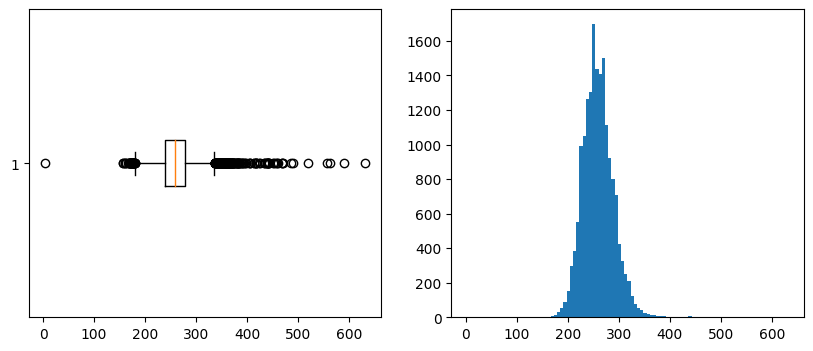

In [115]:
# show the number of times each event occurs
print("Number of events per type over 10 years")
print(df['event_type'].value_counts())

# show the distribution of events per game
events_per_game = df.groupby('game_id').count()['event_type']
print("Events per game")
plt.subplot(1,2,1)
plt.boxplot(events_per_game, vert=False)
plt.subplot(1,2,2)
plt.hist(events_per_game, bins=100)
plt.gcf().set_size_inches(10, 4)
plt.show()

In [104]:
# print a correlation matrix between the columns probability_1, probability_2, probability_3
corr = probabilities_avg[['probability_1', 'probability_2', 'probability_3']].corr()
display(corr)

,probability_1,probability_2,probability_3
probability_1,1.0000000,0.7953449,0.5956938
probability_2,0.7953449,1.0000000,0.5951818
probability_3,0.5956938,0.5951818,1.0000000


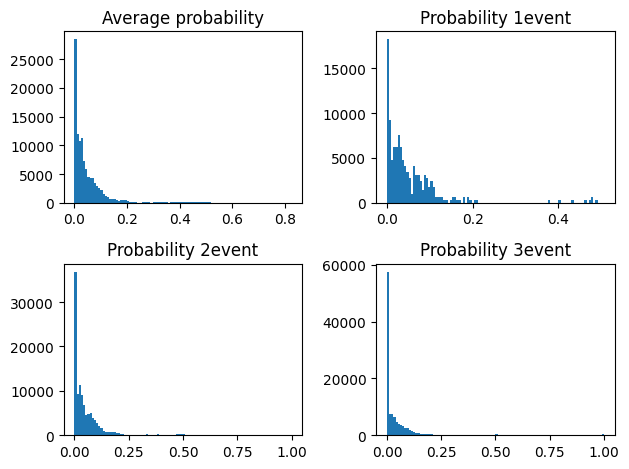

In [120]:

plt.subplot(2, 2, 1)
plt.hist(probabilities_avg['probability_avg'], label="avg", bins=100)
plt.title("Average probability")

plt.subplot(2, 2, 2)
plt.hist(probabilities_avg['probability_1'], label="1event", bins=100)
plt.title("Probability 1event")

plt.subplot(2, 2, 3)
plt.hist(probabilities_avg['probability_2'], label="2event", bins=100)
plt.title("Probability 2event")

plt.subplot(2, 2, 4)
plt.hist(probabilities_avg['probability_3'], label="3event", bins=100)
plt.title("Probability 3event")

plt.tight_layout()
plt.show()


# seconds in game analysis

In [138]:
display(df_orig[df_orig['game_id'] == 2010020048])

,event_type,game_seconds_remaining,event_team_type,home_final,game_id,home_final,away_final,home_name,away_name
28622,GAME_SCHEDULED,3600,NaN,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28623,CHANGE,3600,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28624,CHANGE,3600,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28625,FACEOFF,3600,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28626,SHOT,3569,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
...,...,...,...,...,...,...,...,...,...
29125,SHOT,3,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29126,CHANGE,0,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29127,CHANGE,0,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29128,PERIOD_END,0,NaN,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche


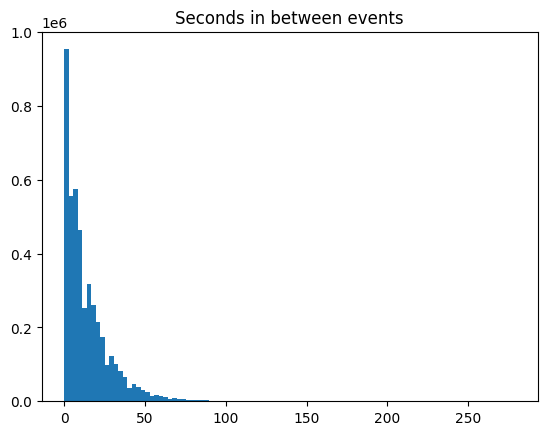

In [12]:
plt.title("Seconds in between events")
df_events['minutes_diff'] = df_events['seconds_diff'] / 60
df_events = df_events[df_events['seconds_diff'] < 400]

plt.hist(df_events['seconds_diff'], bins=100)
plt.show()

# simulate a game

In [68]:
#probs = pd.read_csv("data/probabilities_avg.csv")
probs = pd.read_csv("data/probabilities_avg_NOHIT.csv")
display(probs)

events = probs['curr_event'].unique()
print(events)

,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921664,0.4921664,0.4921664,0.4921664,17425,17425.0000000,17425.0000000,8576.0000000,8576.0000000,8576.0000000
1,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
3,#,#,#,SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,MISSED_SHOT_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,17425,17425.0000000,17425.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88735,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,TAKEAWAY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88736,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,GOAL_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88737,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88738,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_HOME,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


['FACEOFF_AWAY' 'GIVEAWAY_HOME' 'BLOCKED_SHOT_AWAY' 'SHOT_AWAY'
 'MISSED_SHOT_AWAY' 'GIVEAWAY_AWAY' 'BLOCKED_SHOT_HOME' 'FACEOFF_HOME'
 'SHOT_HOME' 'GOAL_HOME' 'TAKEAWAY_HOME' 'MISSED_SHOT_HOME'
 'TAKEAWAY_AWAY' 'GOAL_AWAY' 'PENALTY_AWAY' 'PENALTY_HOME'
 'BLOCKED_SHOT_-']


In [69]:
# more or less normalize the probabilities
probs_sums = (probs
    .copy()
    .groupby(by=['prev3', 'prev2', 'prev1'])
    [['probability_avg', 'probability_1', 'probability_2', 'probability_3']]
    .sum()
    .reset_index()
    .rename(columns={
        'probability_avg': 'probability_avg_sum',
        'probability_1': 'probability_1_sum',
        'probability_2': 'probability_2_sum',
        'probability_3': 'probability_3_sum'}))

display(probs_sums)

probs2 = pd.merge(probs, probs_sums, on=['prev3', 'prev2', 'prev1'], how='left')
probs2['probability_avg'] /= probs2['probability_avg_sum']
probs2['probability_1'] /= probs2['probability_1_sum']
probs2['probability_2'] /= probs2['probability_2_sum']
probs2['probability_3'] /= probs2['probability_3_sum']
probs2 = probs2.drop(columns=[
    'probability_avg_sum', 'probability_1_sum', 'probability_2_sum', 'probability_3_sum'])

probs2 = probs2.fillna(0)
display(probs2)

,prev3,prev2,prev1,probability_avg_sum,probability_1_sum,probability_2_sum,probability_3_sum
0,#,#,#,1.0000000,1.0000000,1.0000000,1.0000000
1,#,#,BLOCKED_SHOT_-,0.3333333,1.0000000,0.0000000,0.0000000
2,#,#,BLOCKED_SHOT_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
3,#,#,BLOCKED_SHOT_HOME,1.0000000,1.0000000,1.0000000,1.0000000
4,#,#,FACEOFF_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...
5215,TAKEAWAY_HOME,TAKEAWAY_HOME,PENALTY_HOME,1.0000000,1.0000000,1.0000000,1.0000000
5216,TAKEAWAY_HOME,TAKEAWAY_HOME,SHOT_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
5217,TAKEAWAY_HOME,TAKEAWAY_HOME,SHOT_HOME,1.0000000,1.0000000,1.0000000,1.0000000
5218,TAKEAWAY_HOME,TAKEAWAY_HOME,TAKEAWAY_AWAY,1.0000000,1.0000000,1.0000000,1.0000000


,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921664,0.4921664,0.4921664,0.4921664,17425,17425.0000000,17425.0000000,8576.0000000,8576.0000000,8576.0000000
1,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
3,#,#,#,SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,MISSED_SHOT_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,17425,17425.0000000,17425.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88735,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,TAKEAWAY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88736,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,GOAL_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88737,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_AWAY,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
88738,BLOCKED_SHOT_-,BLOCKED_SHOT_-,BLOCKED_SHOT_-,PENALTY_HOME,0.0000000,0.0000000,0.0000000,0.0000000,7,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [70]:
seconds_distr = df_events['seconds_diff'].to_numpy()

# fit a gaussian KernelDensity on seconds_distr
# Import the necessary module
# Fit a Gaussian KernelDensity on seconds_distr
kde = KernelDensity(kernel='gaussian').fit(seconds_distr[:, np.newaxis])

# sample 10 times from this kde
samples = kde.sample(100000).astype(int).flatten()


In [76]:
import pickle
with open("data/pickles/kde_seconds_NOHIT.pickle", "wb") as file:
    pickle.dump(kde, file)

In [71]:
# simulate the frickin game

n_games = 1000
i = 0

games = []

game_bar = tqdm(total=n_games)

for game_id in range(n_games):
    
    game_id = str(game_id).zfill(8)
    
    seconds_remaining = 3600
    
    prev3 = "#"
    prev2 = "#"
    prev1 = "#"
    
    home_score = 0
    away_score = 0
    
    curr_dict = {e:0 for e in events}
    curr_dict['time_remaining'] = seconds_remaining
    
    game_dicts = [curr_dict.copy()]
    
    while seconds_remaining > 0:
        
        game_bar.set_description(str(seconds_remaining))
        
        curr_table = probs2[(probs['prev3'] == prev3) & (probs2['prev2'] == prev2) & (probs2['prev1'] == prev1)]

        curr_event = np.random.choice(curr_table['curr_event'], p=curr_table['probability_avg'])
        prev3, prev2, prev1 = prev2, prev1, curr_event
        
        event_time = samples[i]
        i += 1
        
        seconds_remaining -= event_time
        
        curr_dict['time_remaining'] = seconds_remaining
        curr_dict[curr_event] += 1
        game_dicts.append(curr_dict.copy())
            
    game_bar.update(1)
            
        
    game_df = pd.DataFrame(game_dicts)
    game_df['game_id'] = game_id
    game_df['home_score'] = home_score
    game_df['away_score'] = away_score
    games.append(game_df)

    
    
        
        
        

  0%|          | 0/5 [00:00<?, ?it/s]

In [75]:
games_full = pd.concat(games).reset_index(drop=True)

last_rows = games_full['game_id'].shift(-1) != games_full['game_id']
last_rows_df = games_full.loc[last_rows, :].copy()
last_rows_df = movecol(last_rows_df, ['GOAL_HOME', 'GOAL_AWAY'], games_full.columns[0], 'Before')
display(last_rows_df)

,GOAL_HOME,GOAL_AWAY,FACEOFF_AWAY,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY,SHOT_AWAY,MISSED_SHOT_AWAY,GIVEAWAY_AWAY,BLOCKED_SHOT_HOME,FACEOFF_HOME,SHOT_HOME,TAKEAWAY_HOME,MISSED_SHOT_HOME,TAKEAWAY_AWAY,PENALTY_AWAY,PENALTY_HOME,BLOCKED_SHOT_-,time_remaining,game_id,home_score,away_score
226,1,1,27,13,22,32,19,7,18,27,25,10,10,5,5,4,0,-2,00000000,0,0
464,5,1,36,12,21,36,9,9,11,23,32,11,18,7,1,5,0,-17,00000001,0,0
654,3,1,29,11,11,19,8,8,15,19,24,7,20,3,5,6,0,-30,00000002,0,0
814,4,4,17,5,10,28,9,11,9,20,22,6,8,4,1,1,0,-126,00000003,0,0
1016,2,3,32,9,16,22,11,6,6,25,37,6,13,4,4,5,0,-3,00000004,0,0


# checking how simulation matches actual games

In [79]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full.feather")
display(df)

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters
0,2010-10-07,2010-10-07T23:15:46Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Pittsburgh Penguins,home,REGULAR,1,0,1200.0000000,0,3600,0,0,2.0000000,3.0000000,5v4,PP,Power Play,-,False,5.0000000,4.0000000
1,2010-10-07,2010-10-07T23:16:26Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,BLOCKED_SHOT,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,25,1175.0000000,25,3575,0,0,2.0000000,3.0000000,4v5,SH,Shorthanded,-,False,5.0000000,4.0000000
2,2010-10-07,2010-10-07T23:16:38Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,26,1174.0000000,26,3574,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
3,2010-10-07,2010-10-07T23:17:02Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,FACEOFF,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,29,1171.0000000,29,3571,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
4,2010-10-07,2010-10-07T23:17:12Z,2010020002,Pittsburgh Penguins,Philadelphia Flyers,SHOT,-,0.0000000,Philadelphia Flyers,away,REGULAR,1,32,1168.0000000,32,3568,0,0,2.0000000,3.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526317,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526318,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526319,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000
4526320,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000


In [80]:
df = df_full.copy()
df = df.loc[df['event_type'] == 'HIT', :].copy()


In [141]:
random.seed(42)
As = ['1','2','3']
Bs = [choice(['A','B','C']) for _ in range(10)]
rows = list(product(As, Bs))

df = pd.DataFrame(rows, columns=['game_id', 'event_type'])
df['order'] = df.index.values.copy()
df['count'] = 1
df['random'] = np.random.randint(-3, 3, len(df))
df['random2'] = [choice([True, False]) for _ in range(len(df))]
display(df)

piv_tab = (pd.pivot_table(df, values='count', index=['game_id', 'order'], columns=['event_type'])
           .reset_index()
           .fillna(0))

#piv_tab_cols = [c for c in piv_tab.columns if c != 'B' and c != 'C']
#piv_tab = piv_tab[piv_tab_cols].copy()

for col in ['A','B','C']:

    # get a cumulative sum
    piv_tab[col+"_cumsum"] = piv_tab[col].cumsum()

    # for the last entries of each game, get the different between cumulative sums
    last_rows = piv_tab['game_id'].shift(-1) != piv_tab['game_id']
    last_rows_df = piv_tab.loc[last_rows, :].copy()
    last_rows_df[col+"_cumsum"] = -1*last_rows_df[col+"_cumsum"]
    last_rows_df[col+"_cumsum_diff"] = last_rows_df[col+"_cumsum"].diff().shift(-1).fillna(0)

    # align cumsum_diff with the original dataframe
    piv_tab = pd.merge(piv_tab, last_rows_df[['game_id', 'order', col+"_cumsum_diff"]], on=['game_id', 'order'], how='left')
    piv_tab[col+"_offset"] = piv_tab[col+"_cumsum_diff"].fillna(0)
    piv_tab[col+"_offset2"] = piv_tab[col+"_offset"].shift(1).fillna(0)

    # compute the adjusted column
    piv_tab[col+"_adjusted"] = piv_tab[col].copy() + piv_tab[col+"_offset2"]

    # cumulative sum column'
    piv_tab[col+'_total'] = piv_tab[col+"_adjusted"].cumsum()

    piv_tab = movecol(piv_tab, [col+'_total'], col, 'After')

    drop_cols = [col+'_cumsum', col+'_cumsum_diff', col+'_offset', col+'_offset2', col+"_adjusted"]
    piv_tab = piv_tab.drop(columns=drop_cols)

display(piv_tab)

,game_id,event_type,order,count,random,random2
0,1,C,0,1,-2,True
1,1,A,1,1,-1,False
2,1,A,2,1,2,True
3,1,C,3,1,-1,True
4,1,B,4,1,2,True
5,1,A,5,1,1,True
6,1,A,6,1,-3,True
7,1,A,7,1,2,True
8,1,C,8,1,0,True
9,1,A,9,1,2,False


event_type,game_id,order,A,A_total,B,B_total,C,C_total
0,1,0,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,1.0000000
1,1,1,1.0000000,1.0000000,0.0000000,0.0000000,0.0000000,1.0000000
2,1,2,1.0000000,2.0000000,0.0000000,0.0000000,0.0000000,1.0000000
3,1,3,0.0000000,2.0000000,0.0000000,0.0000000,1.0000000,2.0000000
4,1,4,0.0000000,2.0000000,1.0000000,1.0000000,0.0000000,2.0000000
5,1,5,1.0000000,3.0000000,0.0000000,1.0000000,0.0000000,2.0000000
6,1,6,1.0000000,4.0000000,0.0000000,1.0000000,0.0000000,2.0000000
7,1,7,1.0000000,5.0000000,0.0000000,1.0000000,0.0000000,2.0000000
8,1,8,0.0000000,5.0000000,0.0000000,1.0000000,1.0000000,3.0000000
9,1,9,1.0000000,6.0000000,0.0000000,1.0000000,0.0000000,3.0000000


In [144]:
display(df)
print(np.sum(df['event_team_type'] == '-'))

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order
51,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,0
58,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,1
60,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,2
63,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,3
64,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526317,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712188
4526318,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712189
4526319,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712190
4526320,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712191


7


In [174]:
df = df_full.copy()

# ignore all of the HIT events
df = df.loc[
    (df['event_type'] != 'HIT') &
    (df['event_team_type'] != "-"), :].copy()
df['event_type'] = df['event_type'].astype(str) + '_' + df['event_team_type'].astype(str).str.upper()

df = df.sort_values(by=['game_id', 'game_seconds'], ascending=[True, True])

# add an order column to ensure that the pandas merge works later
df['order'] = np.arange(len(df))

# create a smaller dataframe with just the relevant columns for getting the state counts
count_cols = ['game_id', 'event_type', 'order']
other_cols = [c for c in df.columns if c not in count_cols]
df_rel = df[count_cols].copy()
df_rel['count'] = 1

# pivot the table on the event_type, so that there is a zero for each event
# that occured at each timestep and a 0 for all of the others
piv_tab = (pd.pivot_table(df_rel, 
                        values='count', 
                        index=['game_id', 'order'], 
                        columns=['event_type'])
        .reset_index()
        .fillna(0))

# create the cumulative counts for all of the new event columns in the pivot table
event_cols = [c for c in piv_tab.columns if c != 'game_id' and c != 'order']
pbar = tqdm(total=len(event_cols))
for col in event_cols:
    pbar.set_description(str(col))
    
    piv_tab[col] = piv_tab[col].astype(int)
    
    # get a cumulative sum
    piv_tab[col+"_cumsum"] = piv_tab[col].cumsum()

    # for the last entries of each game, get the different between cumulative sums
    last_rows = piv_tab['game_id'].shift(-1) != piv_tab['game_id']
    last_rows_df = piv_tab.loc[last_rows, :].copy()
    last_rows_df[col+"_cumsum"] = -1*last_rows_df[col+"_cumsum"]
    last_rows_df[col+"_cumsum_diff"] = last_rows_df[col+"_cumsum"].diff().fillna(0)
    first_cumsum = last_rows_df.loc[last_rows_df.index[0], col+"_cumsum"]
    last_rows_df.loc[last_rows_df.index[0], col+"_cumsum_diff"] = first_cumsum

    # align cumsum_diff with the original dataframe
    piv_tab = pd.merge(piv_tab, last_rows_df[['game_id', 'order', col+"_cumsum_diff"]], on=['game_id', 'order'], how='left')
    piv_tab[col+"_offset"] = piv_tab[col+"_cumsum_diff"].fillna(0)
    piv_tab[col+"_offset2"] = piv_tab[col+"_offset"].shift(1).fillna(0)

    # compute the adjusted column
    piv_tab[col+"_adjusted"] = piv_tab[col].copy() + piv_tab[col+"_offset2"]

    # cumulative sum column'
    piv_tab[col+'_raw'] = piv_tab[col].copy()
    piv_tab[col+'_total'] = piv_tab[col+"_adjusted"].cumsum().astype(int)

    # only keep the new total column (get rid of the intermediate columns)
    piv_tab = movecol(piv_tab, [col+'_total', col+'_raw'], col, 'After')
    piv_tab = piv_tab.drop(columns=[col])
    piv_tab = piv_tab.rename(columns={col+'_total': col})
    drop_cols = [col+'_cumsum', col+'_cumsum_diff', col+'_offset', col+'_offset2', col+"_adjusted"]
    piv_tab = piv_tab.drop(columns=drop_cols)
    
    pbar.update(1)

df = df.merge(piv_tab, on=['game_id', 'order'], how='left') 
df.reset_index(drop=True).to_feather("data/play_by_play/play_by_play_full_counts.feather")
display(df)

  0%|          | 0/16 [00:00<?, ?it/s]

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,BLOCKED_SHOT_AWAY,BLOCKED_SHOT_AWAY_raw,BLOCKED_SHOT_HOME,BLOCKED_SHOT_HOME_raw,FACEOFF_AWAY,FACEOFF_AWAY_raw,FACEOFF_HOME,FACEOFF_HOME_raw,GIVEAWAY_AWAY,GIVEAWAY_AWAY_raw,GIVEAWAY_HOME,GIVEAWAY_HOME_raw,GOAL_AWAY,GOAL_AWAY_raw,GOAL_HOME,GOAL_HOME_raw,MISSED_SHOT_AWAY,MISSED_SHOT_AWAY_raw,MISSED_SHOT_HOME,MISSED_SHOT_HOME_raw,PENALTY_AWAY,PENALTY_AWAY_raw,PENALTY_HOME,PENALTY_HOME_raw,SHOT_AWAY,SHOT_AWAY_raw,SHOT_HOME,SHOT_HOME_raw,TAKEAWAY_AWAY,TAKEAWAY_AWAY_raw,TAKEAWAY_HOME,TAKEAWAY_HOME_raw
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,2,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5.0000000,5.0000000,4,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712181,15,0,22,1,17,0,31,0,5,0,10,0,2,0,1,0,10,0,21,0,1,0,1,0,22,0,19,0,1,0,6,0
3712182,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712182,15,0,22,0,17,0,31,0,5,0,10,0,2,0,1,0,10,0,21,0,1,0,1,0,22,0,20,1,1,0,6,0
3712183,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712183,15,0,22,0,17,0,31,0,5,0,10,0,2,0,1,0,10,0,21,0,1,0,1,0,22,0,21,1,1,0,6,0
3712184,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6.0000000,5.0000000,3712184,15,0,22,0,17,0,32,1,5,0,10,0,2,0,1,0,10,0,21,0,1,0,1,0,22,0,21,0,1,0,6,0


# check out simulation

In [92]:
df = pd.concat([
    pd.read_feather('data/simulated_games/nohit_500.feather'),
    pd.read_feather('data/simulated_games/nohit_1000.feather')
])
display(df)

,FACEOFF_AWAY,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY,SHOT_AWAY,MISSED_SHOT_AWAY,GIVEAWAY_AWAY,BLOCKED_SHOT_HOME,FACEOFF_HOME,SHOT_HOME,GOAL_HOME,TAKEAWAY_HOME,MISSED_SHOT_HOME,TAKEAWAY_AWAY,GOAL_AWAY,PENALTY_AWAY,PENALTY_HOME,BLOCKED_SHOT_-,time_remaining,game_id,home_score,away_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3600,00000000,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3582,00000000,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3569,00000000,0,0
3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3568,00000000,0,0
4,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3560,00000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212479,32,10,20,21,6,13,20,31,28,2,13,18,5,3,4,4,0,272,00000999,0,0
212480,32,10,20,21,7,13,20,31,28,2,13,18,5,3,4,4,0,71,00000999,0,0
212481,32,10,20,21,7,13,20,32,28,2,13,18,5,3,4,4,0,45,00000999,0,0
212482,32,10,20,21,7,13,21,32,28,2,13,18,5,3,4,4,0,16,00000999,0,0


In [94]:
last_rows = df['game_id'].shift(-1) != df['game_id']
df_last = df.loc[last_rows, :].copy()

display(df_last['GOAL_AWAY'].value_counts().sort_index())
display(df_last['GOAL_HOME'].value_counts().sort_index())

GOAL_AWAY
0      69
1     239
2     385
3     307
4     263
5     138
6      68
7      22
8       7
9       1
11      1
Name: count, dtype: int64

GOAL_HOME
0      74
1     208
2     320
3     328
4     275
5     157
6      91
7      29
8      11
9       4
10      2
11      1
Name: count, dtype: int64

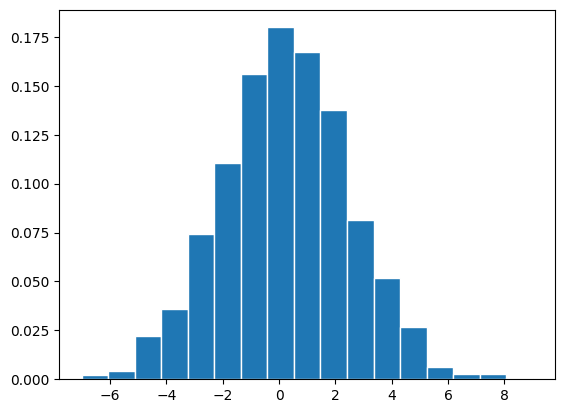

In [99]:
diff = df_last['GOAL_HOME'] - df_last['GOAL_AWAY']
plt.hist(diff, bins=len(diff.unique()), edgecolor='white', density=True)
plt.show()

In [116]:
display(df_last)
df_last.reset_index(drop=True).to_feather('data/simulated_games/lasts.feather')

,FACEOFF_AWAY,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY,SHOT_AWAY,MISSED_SHOT_AWAY,GIVEAWAY_AWAY,BLOCKED_SHOT_HOME,FACEOFF_HOME,SHOT_HOME,GOAL_HOME,TAKEAWAY_HOME,MISSED_SHOT_HOME,TAKEAWAY_AWAY,GOAL_AWAY,PENALTY_AWAY,PENALTY_HOME,BLOCKED_SHOT_-,time_remaining,game_id,home_score,away_score
231,40,10,15,30,10,5,18,28,30,3,7,9,8,3,5,10,0,-7,00000000,0,0
417,23,10,11,30,15,7,6,28,24,0,5,13,3,0,4,6,0,-5,00000001,0,0
634,18,5,10,31,14,10,12,35,33,0,7,17,9,1,9,5,0,-36,00000002,0,0
870,38,11,17,23,7,12,21,29,37,2,8,8,13,4,2,3,0,-16,00000003,0,0
1072,30,6,10,25,6,4,22,22,35,3,6,14,5,4,2,7,0,-14,00000004,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211595,25,15,10,27,15,13,13,46,34,4,3,20,7,2,9,4,0,-3,00000995,0,0
211818,28,7,18,21,12,12,19,34,32,2,8,12,10,3,2,2,0,-1,00000996,0,0
212047,27,11,15,36,12,6,8,39,26,1,14,13,6,7,5,2,0,-82,00000997,0,0
212248,23,11,9,20,9,12,12,30,38,3,6,15,3,4,2,3,0,-3,00000998,0,0
